<div style="display: flex; background-color: RGB(51,165,182);" >
<h1 style="margin: auto; padding: 30px; color:#fff; "> Project 12: Counterfeit bills prediction - What machine learning model?
 </h1>
</div>

# Part 1 - Import packages & functions

In [1]:
import os #To retrieve data from repository
import pandas as pd #For DataFrame features
import numpy as np #Mainly for Array & mathematics features
from tabulate import tabulate
#import random #Needed for randomize function

###For file management
from pathlib import Path
###To save models
import joblib
import pickle

###For data vizualisation
import matplotlib.pyplot as plt #For simple visuals with Matplotlib, interesting for quick visualisation
import seaborn as sns #For medium visuals with seaborn (ex: heatmap)
import plotly.express as px #For advanced visuals with PlotlyExpress, preferred when presenting results, as some nice features for zooming
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
#from ipywidgets import interact #For advanced interaction in visuals

###For statistical tests
from scipy.stats import shapiro # For normalization test

### For data preparation
from sklearn.model_selection import train_test_split #For data preparation
from sklearn.preprocessing import StandardScaler #For data preparation/normalization
from sklearn.preprocessing import MinMaxScaler #For data preparation/normalization
from sklearn.datasets import make_classification

### For machine learning model evaluation and optimization
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, r2_score,
    classification_report, mean_squared_error, mean_absolute_percentage_error,
    silhouette_score
)
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Needed for unsupervised learning models
#|Linear models
from sklearn.linear_model import LinearRegression, LogisticRegression
#|Tree-based models
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier


#Needed for supervised learning models
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


###To use PCA functions, so that to reduce dimensions for analysis
from sklearn.decomposition import PCA

# Part 2.1 - Import, explore & prepare the data

## Import data

In [2]:
def import_data(file_path: str, separator: str = ";", encoding: str = "utf-8") -> pd.DataFrame:
    """
    Importe un fichier CSV et retourne un DataFrame.
    Paramètres :
    - file_path (str) : Chemin du fichier CSV à importer.
    - separator (str, optionnel) : Délimiteur du fichier (par défaut ";").
    - encoding (str, optionnel) : Encodage du fichier (par défaut "utf-8").
    Retour :
    - df (pd.DataFrame) : DataFrame contenant les données importées.
    """
    file_path = Path(file_path)  # Convertir en objet Path
    if not file_path.exists():
        raise FileNotFoundError(f"❌ Le fichier '{file_path}' n'existe pas.")
    df = pd.read_csv(file_path, sep=separator, encoding=encoding)
    print(f"✅ Data imported successfully from {file_path.name} ({df.shape[0]} rows, {df.shape[1]} columns)")
    return df

In [3]:
#from scripts.Part2_ImportExportData import import_data #Import function from scripts
input_path = r"c:\Users\chimy\Documents\_myWorks\2024_Openclassrooms_data\P12\Data_in_P12\billets.csv" #Set up the path where to retrieve the input data file
df = import_data(input_path) #Load data

✅ Data imported successfully from billets.csv (1500 rows, 7 columns)


## Analysis & preparation

### Quick discovery of the source data

In [4]:
df.info()
#df.shape[0] if to only have the number of lines
###OBSERVATIONS: SOME MISSING VALUES FOR margin_low

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
df.describe().round(2)
# This gives a 1st view of global dispersion of values. For something more precise, diagram to build.

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


#### Do we have duplicated rows? ==> NO

In [6]:
### IF NEEDED TO CHECK IF DUPLICATED ROWS
df.duplicated().sum()
# If 0, so no duplicated rows

0

#### Do we have missing values? ==> YES, 53 of margin_low 

In [7]:
### IF NEEDED TO DISPLAY DETAILS FOR MISSING VALUES
#df.isna().mean()
#If results are not 0, so we have missing values. 
#For instance, as 0.024667 for margin_low (as we are counting the average of True/1, as True = Missing values). We are having 2.4% of missing values for this variable.

df_missingvalues = df[df.isna().any(axis=1)]
#To display the missing values
#WHAT TO DO WITH THEM? Too many to delete full lines. TO REPLACE BY MEAN??

In [8]:
df_missingvalues.shape[0]

37

In [9]:
df_missingvalues['is_genuine'].eq(False).sum()
## 8 of them are Fake Bills, which means 15% of missing values are fake bills

8

In [10]:
df_withoutmissingvalues = df.dropna()
#df_clean = df[~df.index.isin(missingvalues.index)]  #As other alternative

#### Do we have outliers? ==> YES, 24 to 53 (mainly margin_low)

In [11]:
### FOR OUTLIERS: Define to get all outliers using the IQR method
def get_outliers_withIQR(df, threshold=2):
    """
    Détecte les outliers dans toutes les colonnes numériques d'un DataFrame
    en utilisant la méthode IQR (Interquartile Range).
    Arguments :
    df : pd.DataFrame - Le DataFrame contenant les données
    Retour :
    df_outliers : pd.DataFrame - Un DataFrame contenant uniquement les lignes ayant au moins un outlier
    """
    outlier_mask = pd.DataFrame(False, index=df.index, columns=df.columns)  # Initialisation d'un masque False
    for col in df.select_dtypes(include=['number']).columns:  # Boucle sur chaque colonne numérique
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        seuil_inf = Q1 - threshold * IQR
        seuil_sup = Q3 + threshold * IQR
        outlier_mask[col] = (df[col] < seuil_inf) | (df[col] > seuil_sup) # Création du masque pour identifier les outliers
    outliers_df = df[outlier_mask.any(axis=1)] # Filtrer les lignes contenant au moins un outlier
    print("With IQR method, we have {} outlier(s)".format(outliers_df.shape[0]))
    print("As a reminder, our initial datasets contains {} invidual(s)".format(df.shape[0]))
    return outliers_df

### FOR OUTLIERS: Define to get all outliers using the Zscore
def get_outliers_withZscore(df, threshold=3):
    """
    Renvoie un DataFrame contenant uniquement les lignes avec des outliers.
    Paramètres :
    ------------
    df : DataFrame
        Le DataFrame contenant les données.
    threshold : float (default=3)
        Seuil du Z-score pour considérer une valeur comme un outlier.
    Retourne :
    ----------
    DataFrame contenant uniquement les lignes avec au moins un outlier.
    """
    # Calcul des z-scores
    z_scores = (df - df.mean()) / df.std()
    # Identification des outliers
    outliers = (z_scores.abs() > threshold).astype(int)
    # Filtrage des lignes contenant au moins un outlier
    rows_with_outliers = outliers.sum(axis=1) > 0
    outliers_indices = outliers[rows_with_outliers].index.tolist()
    # Extraction des lignes correspondantes du DataFrame original
    outliers_df = df.loc[outliers_indices]
    print("With ZScore method, we have {} outlier(s)".format(outliers_df.shape[0]))
    print("As a reminder, our initial datasets contains {} invidual(s)".format(df.shape[0]))
    return outliers_df

In [12]:
outliers_withIQR = get_outliers_withIQR(df, threshold=1.5)
outliers_withZscore = get_outliers_withZscore(df, threshold=3)

With IQR method, we have 53 outlier(s)
As a reminder, our initial datasets contains 1500 invidual(s)
With ZScore method, we have 24 outlier(s)
As a reminder, our initial datasets contains 1500 invidual(s)


#### How distinct are values per variable?

In [13]:
df.nunique()
# Higher the number of distintcs values, higher diversity of values we have per variable.

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

### Distribution & normalisation

#### How is the distribution of our quantitative variables?

In [14]:
# TO DISPLAY ALL HISTOGRAMS & BOXPLOTS IN 1 LINE
def display_histogram_boxplot(df):
    #Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Définition des couleurs pour chaque variable
    colors = px.colors.qualitative.Plotly  # Palette de couleurs
    color_dict = {col: colors[i % len(colors)] for i, col in enumerate(numeric_cols)}  # Assigner une couleur par variable

    # Création des subplots avec des proportions différentes
    fig = make_subplots(
        rows=2, 
        cols=len(numeric_cols), 
        row_heights=[0.8, 0.2],  # 80% pour histogrammes, 20% pour boxplots
        #subplot_titles=[f"{col} - Histogram" for col in numeric_cols] + 
        #              [f"{col} - Boxplot" for col in numeric_cols]
    )

    # Ajout des histogrammes en ligne 1
    for i, col in enumerate(numeric_cols):
        fig.add_trace(
            go.Histogram(x=df[col], nbinsx=50, opacity=0.7, name=col, marker_color=color_dict[col]), 
            row=1, col=i+1
        )

    # Ajout des boxplots en ligne 2 avec index en hover
    for i, col in enumerate(numeric_cols):
        fig.add_trace(
            go.Box(
                x=df[col], 
                name=col, 
                marker_color=color_dict[col], 
                text=df.index,  # Ajout des index
                hoverinfo="text"  # Afficher index + valeur en hover
            ), 
            row=2, col=i+1
        )

    # Mise en forme
    fig.update_layout(
        title_text="Distribution of all quantitative variables",
        showlegend=True,  # Active la légende si nécessaire
        font=dict(
            #family="Times New Roman",
            size=10
        ),
        height=700,  # Hauteur totale ajustée
        width=200 * len(numeric_cols),  # Largeur adaptative
    )
    fig.show()

In [15]:
display_histogram_boxplot(df)

#### What about normalization test (with Shapiro)? ==> Highly probable that we are following the normal distributions (even with minor doubts for margin_low, margin_up and length) ==> Should we use other normalization test like Kolmogorov-Smirnov?

In [16]:
### TO TEST ALL VARIABLES WITH SHAPIRO --> Normalization test, better than just having a data vizualization
def get_shapiro(df, alpha=0.05):
    """
    Effectue le test de Shapiro-Wilk pour tester la normalité des données de chaque colonne.
    Args:
    - df : DataFrame contenant les données.
    - numeric_cols : Liste des colonnes numériques sur lesquelles appliquer le test.
    - alpha : Seuil de signification pour le test (par défaut 0.05).
    Affiche les résultats du test pour chaque colonne.
    """
    #Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    for col in numeric_cols:
        # Supprimer les valeurs manquantes dans la colonne
        col_data = df[col].dropna()
        
        # Effectuer le test de Shapiro-Wilk
        W_stat, p_value = shapiro(col_data)

        # Arrondir la valeur p à 4 décimales
        p_value_rounded = round(p_value, 4)

        # Afficher les résultats
        print(f"Variable: {col}")
        print(f"Shapiro-Wilk test statistic: {W_stat}")
        print(f"Rounded p_Value : {p_value_rounded}")

        # Interprétation des résultats
        if p_value_rounded > alpha:
            print("We are following a normal distribution (H0 hypothesis is not rejected)")
        else:
            print("We are NOT following a normal distribution (H0 hypothesis is REJECTED, as we might have enough evidences)")

        print("-" * 40)  # Ligne pour séparer les résultats pour chaque colonne

In [17]:
get_shapiro(df, alpha=0.05)
#WARNING, Shapiro test is sensitive to missing values. So we have excluded them from margin_low.
#The closer W statistics is from 1, the closer to gaussian distribution we have.
#Shapiro works well for sample less than 2000 individuals. If higher, we risk rejected H0 even if minor deviations.

Variable: diagonal
Shapiro-Wilk test statistic: 0.9986855387687683
Rounded p_Value : 0.3234
We are following a normal distribution (H0 hypothesis is not rejected)
----------------------------------------
Variable: height_left
Shapiro-Wilk test statistic: 0.9979010820388794
Rounded p_Value : 0.0509
We are following a normal distribution (H0 hypothesis is not rejected)
----------------------------------------
Variable: height_right
Shapiro-Wilk test statistic: 0.9995179772377014
Rounded p_Value : 0.9806
We are following a normal distribution (H0 hypothesis is not rejected)
----------------------------------------
Variable: margin_low
Shapiro-Wilk test statistic: 0.9377837181091309
Rounded p_Value : 0.0
We are NOT following a normal distribution (H0 hypothesis is REJECTED, as we might have enough evidences)
----------------------------------------
Variable: margin_up
Shapiro-Wilk test statistic: 0.9961656928062439
Rounded p_Value : 0.0008
We are NOT following a normal distribution (H0 hyp

#### What about skewness?

In [18]:
### TO ESTIMATE ALL VARIABLES SKEWNESS
def get_skewness(df):
    """
    Computes and prints the skewness for each numeric column in the DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    
    Returns:
    --------
    None
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Loop through each numeric column
    for col in numeric_cols:
        # Remove missing values for the column
        col_data = df[col].dropna()
        
        # Compute skewness
        skewness = col_data.skew()
        
        # Print results
        print(f"Variable: {col}")
        print(f"Skewness: {skewness}")
        print("-" * 40)  # Line separator between results for each column


In [19]:
get_skewness(df)

Variable: diagonal
Skewness: -0.03330670158414046
----------------------------------------
Variable: height_left
Skewness: -0.09212062623390109
----------------------------------------
Variable: height_right
Skewness: -0.0003275471945634819
----------------------------------------
Variable: margin_low
Skewness: 0.8630655172248257
----------------------------------------
Variable: margin_up
Skewness: 0.1459378262087844
----------------------------------------
Variable: length
Skewness: -0.8159565381523239
----------------------------------------


### Others

In [20]:
df_counts = df['is_genuine'].value_counts().reset_index()
df_counts.columns = ['is_genuine', 'count']

#Source for pie chart in plotly express https://plotly.com/python/pie-charts/
fig = px.pie(df_counts, values='count', names='is_genuine', title='Distribution of real & fake bills', width=400, height=500)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide')
fig.show()

# Part 2.2 - Data preparation: Predictive analysis to complete missing values for margin_low

## Can we guess our missing values for margin_low? Is there any predictive model we can use for it? ==> Multivariable Linear Regression (justified as we have rectangular bills, so a Pythagore Theorem can help to define a linear function)

### What about the correlations between 2 variables?

Text(0.5, 1.0, 'Any linear correlations between our variables?')

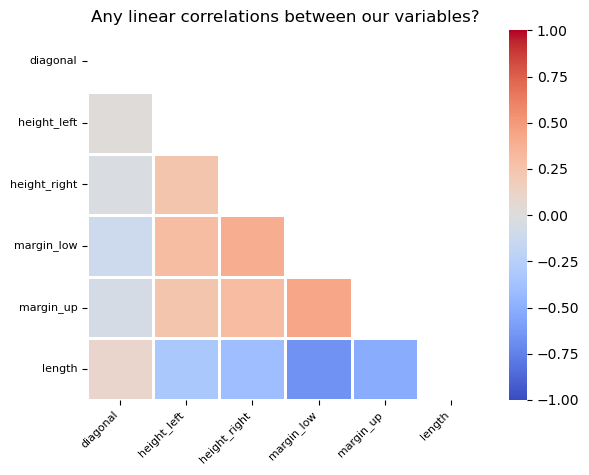

In [21]:
# Looking for linear correlation between selected variables
corr_matrix = df.drop('is_genuine', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, linewidths=2)
# Mise à jour des axes x et y
plt.yticks(font=dict(size=8))
plt.xticks(rotation=45, ha="right", font=dict(size=8))  # Incline à 45° et aligne à droite
#add title
plt.title('Any linear correlations between our variables?')


### Let's try multivariable linear regression prediction?

In [22]:
# Split into known and missing
df_known = df.dropna()
df_missing = df[df['margin_low'].isna()]

In [23]:
# Train Linear Regression Model
X_train, X_test, y_train, y_test = train_test_split(df_known[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']], df_known['margin_low'], test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [24]:
# Predict missing values
df.loc[df['margin_low'].isna(), 'margin_low'] = reg.predict(df_missing[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']])

R² Score: 0.5458
Intercept: 20.396009801378366
Coefficients: [-0.087151    0.15474474  0.25994669  0.29097436 -0.39898675]
 margin_low = -0.09 * diagonal + 0.15 * height_left + 0.26 * height_right + 0.29 * margin_up + -0.4 *  length + noise
        Feature            VIF
0         const  590198.238883
1      diagonal       1.013613
2   height_left       1.138261
3  height_right       1.230115
4     margin_up       1.404404
5        length       1.576950


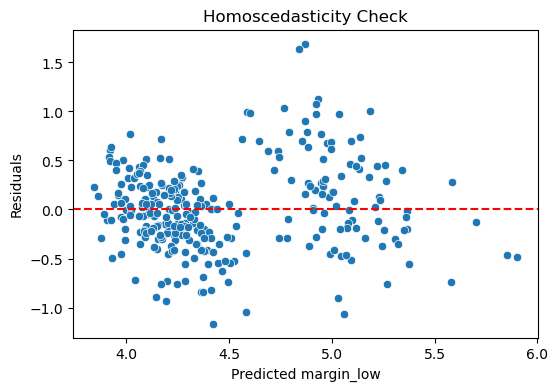

c:\Users\chimy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



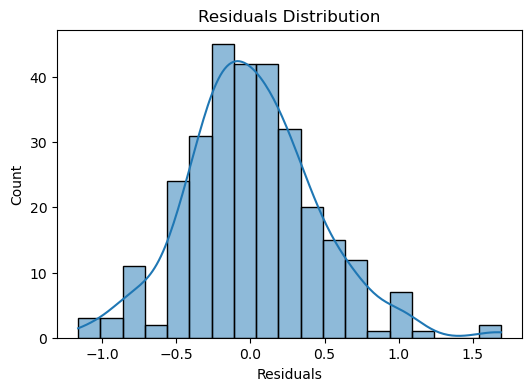

In [25]:
# Calculate R^2, Intercept, and coefficients
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')
print("Intercept:", reg.intercept_)
print("Coefficients:", reg.coef_)
print(f" margin_low = {np.round(reg.coef_[0],  2)} * diagonal + {np.round(reg.coef_[1],  2)} * height_left + {np.round(reg.coef_[2],  2)} * height_right + {np.round(reg.coef_[3],  2)} * margin_up + {np.round(reg.coef_[4],  2)} *  length + noise")

# Check for Multicollinearity (VIF)
X_vif = sm.add_constant(df_known[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']])
vif_data = pd.DataFrame({
    'Feature': X_vif.columns, 
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]})
print(vif_data)

# Residuals Analysis
residuals = y_test - y_pred

# Homoscedasticity Check
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted margin_low')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.show()

# Residual Normality Check
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()

### Testing linear regression using different number of variables

In [26]:
#### IMPORTANT: REUSE df_withoutmissingvalues to train the linear regression model
# Load all predictive variables in X
X = df_withoutmissingvalues[['is_genuine', 'diagonal','height_left']]
# Define our target variable
y = df_withoutmissingvalues.margin_low
# Split the datasets as 80% for training, 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Import and set our linear regression model
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression()

from sklearn.metrics import r2_score

# Train this model with our data with fit method
reg1.fit(X_train, y_train)

# Get linear regression score
print(f"R^2 (score) : {np.round(reg1.score(X_train, y_train), 3)}") #Score as R² for regression models, and as Accuracy for classification models
print("Intercept:", reg1.intercept_)
print("Coefficients:", reg1.coef_)

# Get coefficients of linear regression ==> margin_low = a*is_genuine + b*diagonal + noise
# print(reg.coef_)
print(f" margin_low = {np.round(reg1.coef_[0],  2)} * is_genuine + {np.round(reg1.coef_[1],  2)} * diagonal + noise")

R^2 (score) : 0.6
Intercept: 4.362201106960792
Coefficients: [-1.09209259e+00  4.35053804e-03  9.31554814e-04]
 margin_low = -1.09 * is_genuine + 0.0 * diagonal + noise


In [27]:
# To compare y_test (as real values) with y_pred_test (as the one guessed by the model). Let see how big are the errors with RMSE & MAPE.
y_pred_test = reg1.predict(X_test)
print(f"RMSE: {np.round(mean_squared_error(y_test, y_pred_test),3)}")
print(f"MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred_test),3)}")
### THE SMALLER ARE RMSE & MAPE, THE BETTER IS THE MODEL. For info, MAPE is between 0 and 1


RMSE: 0.14
MAPE: 0.065


In [28]:
#### IMPORTANT: REUSE df_withoutmissingvalues to train the linear regression model
# Load all predictive variables in X
X = df_withoutmissingvalues[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
# Define our target variable
y = df_withoutmissingvalues.margin_low
# Split the datasets as 80% for training, 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Import and set our linear regression model
from sklearn.linear_model import LinearRegression
reg2 = LinearRegression()

# Train this model with our data with fit method
reg2.fit(X_train, y_train)

# Get linear regression score ##### HIGHER IS R^2 BETTER IS THE MODEL. USUALLY BETTER TO HAVE MANY VARIABLES.
print(f"R^2 : {np.round(reg2.score(X_train, y_train), 3)}") #Score as R² for regression models, and as Accuracy for classification models
print("Intercept:", reg2.intercept_)
print("Coefficients:", reg2.coef_)


# Get coefficients of linear regression ==> margin_low = a*is_genuine + b*diagonal + c*height_left + d*height_right + e*margin_up + f*length + noise
# print(reg.coef_)
print(f" margin_low = {np.round(reg2.coef_[0],  2)} * is_genuine + {np.round(reg2.coef_[1],  2)} * diagonal + {np.round(reg2.coef_[2],  2)} * height_left + {np.round(reg2.coef_[3],  2)} * height_right + {np.round(reg2.coef_[4],  2)} * margin_up + {np.round(reg2.coef_[5],  2)} * length + noise")

R^2 : 0.603
Intercept: 2.763538862968131
Coefficients: [-1.14390267  0.00650699  0.00662486  0.01565439 -0.20224097 -0.00283256]
 margin_low = -1.14 * is_genuine + 0.01 * diagonal + 0.01 * height_left + 0.02 * height_right + -0.2 * margin_up + -0.0 * length + noise


In [29]:
# To compare y_test (as real values) with y_pred_test (as the one guessed by the model). Let see how big are the errors with RMSE & MAPE.
y_pred_test = reg2.predict(X_test)
print(f"RMSE: {np.round(mean_squared_error(y_test, y_pred_test),3)}")
print(f"MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred_test),3)}")
### THE SMALLER ARE RMSE & MAPE, THE BETTER IS THE MODEL. For info, MAPE is between 0 and 1


RMSE: 0.137
MAPE: 0.065


# Part 2.3 - Data preparation: Feature engineering with PCA (Principal Component Analysis)

## Let's prepare the data for PCA: X, y, features, Standard Scaling

In [30]:
target_column="is_genuine"
# Separate features and target variable
X = df.drop(target_column, axis=1).values
y = df[target_column].values
    
# Feature names
features = df.drop(target_column, axis=1).columns

# Index names
index = df.index
    
# Scaler for scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
    
# Return the required data
X, X_scaled, y, features, index

(array([[171.81, 104.86, 104.95,   4.52,   2.89, 112.83],
        [171.46, 103.36, 103.66,   3.77,   2.99, 113.09],
        [172.69, 104.48, 103.5 ,   4.4 ,   2.94, 113.16],
        ...,
        [171.8 , 104.01, 104.12,   5.51,   3.36, 111.95],
        [172.06, 104.28, 104.06,   5.17,   3.46, 112.25],
        [171.47, 104.15, 103.82,   4.63,   3.37, 112.07]]),
 array([[-0.48653957,  2.77412327,  3.16324041,  0.05546738, -1.128325  ,
          0.17365114],
        [-1.63372936, -2.23653528, -0.79966777, -1.08215668, -0.69679916,
          0.47166629],
        [ 2.3978233 ,  1.50475644, -1.29119126, -0.12655247, -0.91256208,
          0.55190114],
        ...,
        [-0.51931643, -0.06524991,  0.61346228,  1.55713115,  0.89984645,
         -0.83501554],
        [ 0.3328817 ,  0.83666863,  0.42914097,  1.04140824,  1.33137229,
         -0.4911519 ],
        [-1.6009525 ,  0.40241156, -0.30814427,  0.22231891,  0.94299904,
         -0.69747008]]),
 array([ True,  True,  True, ..., False,

In [31]:
#idx = ["mean", "std"]
#pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]
# pd.DataFrame(X_scaled) to convert X_scaled NumPy table as a dataframe, so that we can use describe() function
# pd.DataFrame(X_scaled).describe().round(2) will give as a result a dataframe
# .loc[idx, :] to fetch all values for "mean" & "std"
# ==> To confirm that all data has been standardized for PCA, mean as 0, and std as 1.

## Let's execute PCA to find new synthetic variable

In [32]:
### TO EXECUTE PCA, AND TO GET PRINCIPAL COMPONENTS (or SYNTHETIC VARIABLES) BASED ON INITIAL VARIABLES
def get_pca_principalcomponents(X_scaled, features, n_components=4):
    """
    Perform PCA on the scaled dataset and return key PCA results.
    Parameters:
    X_scaled (numpy.ndarray): The standardized features for PCA.
    features (list): List of feature names corresponding to columns in X_scaled.
    n_components (int): Number of principal components to keep (default is 4).
    Returns:
    explained_variance_ratio (numpy.ndarray): Explained variance ratio for each component.
    explained_variance_cumsum (numpy.ndarray): Cumulative explained variance ratio.
    pc_list (list): List of principal component indices.
    pcs_df (pd.DataFrame): DataFrame of principal component loadings (eigenvectors).
    Example usage:
    pca, explained_variance_ratio, explained_variance_cumsum, pc_list, pcs_df = get_pca_principalcomponents(X_scaled, feature_names)
    """
    # Initialize and fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    
    # Explained variance ratio
    explained_variance_ratio = (pca.explained_variance_ratio_ * 100).round(2)
    
    # Cumulative explained variance
    explained_variance_cumsum = explained_variance_ratio.cumsum().round(2)
    
    # Principal component list
    pc_list = [f"PC{i}" for i in range(1, n_components + 1)]
    
    # Principal component loadings (eigenvectors)
    pcs_df = pd.DataFrame(pca.components_, columns=features, index=pc_list).round(2)

    return pca, explained_variance_ratio, explained_variance_cumsum, pc_list, pcs_df

In [33]:
pca, explained_variance_ratio, explained_variance_cumsum, pc_list, pcs_df = get_pca_principalcomponents(X_scaled, features, n_components=4)

In [34]:
## TO PLOT PCA SCREE GRAPH
def plot_pca_variance(pc_list, explained_variance_ratio, explained_variance_cumsum, width=600, height=400):
    df = pd.DataFrame({
        "Principal Component": pc_list,
        "Explained Variance (%)": explained_variance_ratio,
        "Cumulative Variance (%)": explained_variance_cumsum
    })
    fig = px.bar(
        df, x="Principal Component", y="Explained Variance (%)",
        title="Cumulative Explained Variance - Scree Plot",
        template="plotly_white"
    )
    fig.add_trace(go.Scatter(
        x=df["Principal Component"], y=df["Cumulative Variance (%)"],
        mode="lines+markers", name="Cumulative Variance",
        line=dict(color="red", width=2), marker=dict(size=8)
    ))
    fig.update_layout(
        width=width, height=height,
        xaxis_title="Principal Component",
        yaxis_title="Explained Variance (%)",
        legend=dict(x=0.5, y=-0.2, xanchor="center", orientation="h"),
        font=dict(size=12)
    )

    fig.show()

In [35]:
plot_pca_variance(pc_list, explained_variance_ratio, explained_variance_cumsum, width=600, height=400)

## Let's understand our new synthetic variables

Text(0.5, 1.0, 'How are built our new synthetic variables?')

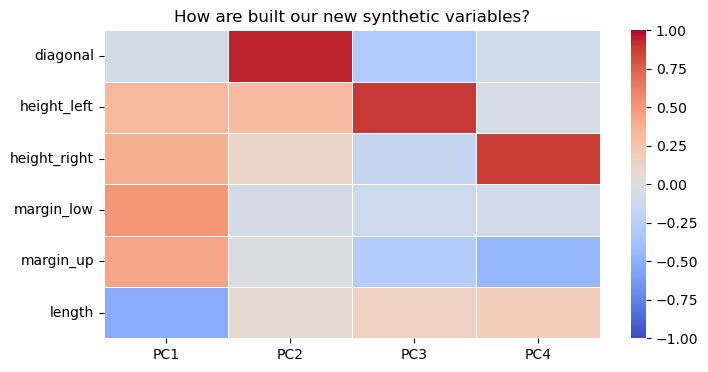

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust figure size
sns.heatmap(pcs_df.T, vmin=-1, vmax=1, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('How are built our new synthetic variables?')
# plt.xticks(rotation=45) #plt.yticks(rotation=0)

In [37]:
## TO PLOT PCA CORRELATION CIRCLE
def plot_pca_correlation_circle(pca, x_y, features, width=600, height=600):
    # Prepare the arrow data and unit circle data
    x, y = x_y
    arrows = pd.DataFrame({'x': pca.components_[x], 'y': pca.components_[y], 'feature': features})
    
    # Unit circle data
    theta = np.linspace(0, 2 * np.pi, 500)
    circle = pd.DataFrame({'x': np.cos(theta), 'y': np.sin(theta)})
    
    # Create figure
    fig = go.Figure()

    # Add the unit circle to the plot
    fig.add_trace(go.Scatter(x=circle['x'], y=circle['y'], mode='lines',
                             name='Unit circle', line=dict(color='gray', dash='dot')))
    
    # Add the feature arrows to the plot
    for _, row in arrows.iterrows():
        fig.add_trace(go.Scatter(x=[0, row['x']], y=[0, row['y']], mode='lines+text',
                                 line=dict(width=2, color='blue'),
                                 text=[None, row['feature']], textposition="top right", 
                                 name=row['feature']))
    
    # Layout update (axes titles and ranges)
    fig.update_layout(
        title=f"Correlation Circle (PC{x+1} & PC{y+1})",
        xaxis_title=f'PC{x+1} ({round(100 * pca.explained_variance_ratio_[x], 1)}%)',
        yaxis_title=f'PC{y+1} ({round(100 * pca.explained_variance_ratio_[y], 1)}%)',
        xaxis=dict(range=[-1.1, 1.1], zeroline=True),
        yaxis=dict(range=[-1.1, 1.1], zeroline=True),
        width=width,
        height=height,
        showlegend=False,
        font=dict(size=10)
    )
    
    # Return the figure object instead of showing it
    return fig


In [38]:
# Create a subplot grid with 1 row and 3 columns
fig = sp.make_subplots(
    rows=1, cols=3, 
    shared_yaxes=False,  # Optional: set to True if you want the same y-axis
    subplot_titles=["Plot 1", "Plot 2", "Plot 3"],  # Titles for each plot
    column_widths=[0.33, 0.33, 0.33]  # Make the plots evenly spaced
)

# First plot (correlation circle between 0 and 1)
plot1 = plot_pca_correlation_circle(pca, (0, 1), features, width=600, height=600)
for trace in plot1.data:
    fig.add_trace(trace, row=1, col=1)  # Add all traces from plot1
# Set axis titles for the first plot
fig.update_xaxes(title_text=f'PC1 ({round(100 * pca.explained_variance_ratio_[0], 1)}%)', row=1, col=1)
fig.update_yaxes(title_text=f'PC2 ({round(100 * pca.explained_variance_ratio_[1], 1)}%)', row=1, col=1)

# Second plot (correlation circle between 1 and 2)
plot2 = plot_pca_correlation_circle(pca, (1, 2), features, width=600, height=600)
for trace in plot2.data:
    fig.add_trace(trace, row=1, col=2)  # Add all traces from plot2
# Set axis titles for the second plot
fig.update_xaxes(title_text=f'PC2 ({round(100 * pca.explained_variance_ratio_[1], 1)}%)', row=1, col=2)
fig.update_yaxes(title_text=f'PC3 ({round(100 * pca.explained_variance_ratio_[2], 1)}%)', row=1, col=2)

# Third plot (correlation circle between 2 and 3)
plot3 = plot_pca_correlation_circle(pca, (2, 3), features, width=600, height=600)
for trace in plot3.data:
    fig.add_trace(trace, row=1, col=3)  # Add all traces from plot3
# Set axis titles for the third plot
fig.update_xaxes(title_text=f'PC3 ({round(100 * pca.explained_variance_ratio_[2], 1)}%)', row=1, col=3)
fig.update_yaxes(title_text=f'PC4 ({round(100 * pca.explained_variance_ratio_[3], 1)}%)', row=1, col=3)

# Update layout for spacing and title
fig.update_layout(
    title_text="PCA Correlation Circle Plots",
    height=500,  # Overall figure height
    width=1200,  # Overall figure width (3 plots side by side)
    showlegend=False  # Disable legend if not needed
)

# Show the figure
fig.show()

## Let's vizualize our samples within the new synthetic variables

### Building our new datasets, based on Principal components, and not on initial variables

In [39]:
X_proj = pca.transform(X_scaled) # X_proj[:5]
df_X_proj = pd.DataFrame(X_proj, columns = ['PC1', 'PC2', 'PC3', 'PC4']) # 'PC5', 'PC6', 'PC7' #df_X_proj.shape[0]
df_X_proj.head()

,PC1,PC2,PC3,PC4
0,1.643924,0.747812,2.404882,3.179559
1,-2.020016,-2.207477,-1.001622,0.073684
2,-0.969844,2.620745,1.193822,-0.925007
3,-1.377681,-1.818425,0.652373,0.828269
4,0.148728,-0.566928,0.854033,-1.787434


### Vizualizing our new datasets in Principal components coordinates

In [40]:
### TO PLOT PCA SCATTER : all samples projected on new synthetic variables, and not on initial variables anymore
def plot_pca_projectiononPC(df_X_proj, components=(0, 1), cluster_labels=None, width=1000, height=700):
    """
    Creates an interactive scatter plot of PCA projections.

    Parameters:
    -----------
    df_X_proj : pd.DataFrame
        DataFrame containing the PCA projections.
    components : tuple, optional
        Indices of the principal components to plot (default: (0,1) for PC1 vs PC2).
    cluster_labels : array-like, optional
        Cluster labels or categories for coloring points (default: None).
    width : int, optional
        Width of the plot (default: 1000).
    height : int, optional
        Height of the plot (default: 700).

    Returns:
    --------
    fig : go.Figure
        The interactive PCA projection plot.
    """
    x, y = components
    df_plot = pd.DataFrame({
        f"PC{x+1}": df_X_proj.iloc[:, x],
        f"PC{y+1}": df_X_proj.iloc[:, y]
    }, index=df_X_proj.index)

    if cluster_labels is not None:
        df_plot["Cluster"] = cluster_labels

    # Create scatter plot
    fig = px.scatter(
        df_plot,
        x=f"PC{x+1}",
        y=f"PC{y+1}",
        color="Cluster" if cluster_labels is not None else None,
        title=f"Projection on PC{x+1} & PC{y+1}",
        labels={f"PC{x+1}": f"PC{x+1} (Axis {x+1})", f"PC{y+1}": f"PC{y+1} (Axis {y+1})", "Cluster": "Clusters"},
        template="plotly"
    )

    # Adjust text position and size
    fig.update_traces(textposition="top center", textfont_size=10)

    # Layout adjustments
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title=f"PC{x+1} ({round(100 * df_X_proj.iloc[:, x].var() / df_X_proj.var().sum(), 1)}%)",
        yaxis_title=f"PC{y+1} ({round(100 * df_X_proj.iloc[:, y].var() / df_X_proj.var().sum(), 1)}%)"
    )

    # Return the figure object for further use
    return fig

In [41]:
plot1 = plot_pca_projectiononPC(df_X_proj, components=(0, 1), cluster_labels=y, width=400, height=400)
for trace in plot1.data:
    fig.add_trace(trace, row=1, col=1)
    
plot1.show()

In [42]:
# Assuming df_X_proj contains the PCA projections and y contains cluster labels:
fig = sp.make_subplots(
    rows=1, cols=3, 
    shared_yaxes=False,
    subplot_titles=["PC1 vs PC2", "PC2 vs PC3", "PC3 vs PC4"],
    column_widths=[0.33, 0.33, 0.33]
)

# First plot (Projection on PC1 & PC2)
plot1 = plot_pca_projectiononPC(df_X_proj, components=(0, 1), cluster_labels=y, width=400, height=400)
for trace in plot1.data:
    fig.add_trace(trace, row=1, col=1)

# Second plot (Projection on PC2 & PC3)
plot2 = plot_pca_projectiononPC(df_X_proj, components=(1, 2), cluster_labels=y, width=400, height=400)
for trace in plot2.data:
    fig.add_trace(trace, row=1, col=2)

# Third plot (Projection on PC3 & PC4)
plot3 = plot_pca_projectiononPC(df_X_proj, components=(2, 3), cluster_labels=y, width=400, height=400)
for trace in plot3.data:
    fig.add_trace(trace, row=1, col=3)

# Update layout for spacing and title
fig.update_layout(
    title_text="PCA Projection Plots",
    height=600,
    width=1200,
    showlegend=True
)

# Show the figure
fig.show()


### Let's explore those new data

In [43]:
df_X_proj.describe().round(2)

,PC1,PC2,PC3,PC4
count,1500.00,1500.00,1500.00,1500.00
mean,0.00,0.00,0.00,0.00
std,1.61,1.01,0.88,0.84
min,-3.36,-3.10,-2.60,-3.12
25%,-1.24,-0.70,-0.58,-0.56
50%,-0.56,0.01,-0.01,-0.00
75%,1.51,0.71,0.54,0.54
max,4.50,3.79,2.96,3.18


In [44]:
outliers_withIQR = get_outliers_withIQR(df_X_proj, threshold=1.5)
outliers_withIQR.shape[0]

With IQR method, we have 44 outlier(s)
As a reminder, our initial datasets contains 1500 invidual(s)


44

In [45]:
outliers_withZscore = get_outliers_withZscore(df_X_proj, threshold=3)
outliers_withZscore.shape[0]

With ZScore method, we have 14 outlier(s)
As a reminder, our initial datasets contains 1500 invidual(s)


14

In [46]:
display_histogram_boxplot(df_X_proj)

In [47]:
get_shapiro(df_X_proj, alpha=0.05)

Variable: PC1
Shapiro-Wilk test statistic: 0.9247293472290039
Rounded p_Value : 0.0
We are NOT following a normal distribution (H0 hypothesis is REJECTED, as we might have enough evidences)
----------------------------------------
Variable: PC2
Shapiro-Wilk test statistic: 0.9989376664161682
Rounded p_Value : 0.531
We are following a normal distribution (H0 hypothesis is not rejected)
----------------------------------------
Variable: PC3
Shapiro-Wilk test statistic: 0.9963779449462891
Rounded p_Value : 0.0013
We are NOT following a normal distribution (H0 hypothesis is REJECTED, as we might have enough evidences)
----------------------------------------
Variable: PC4
Shapiro-Wilk test statistic: 0.9987967014312744
Rounded p_Value : 0.4068
We are following a normal distribution (H0 hypothesis is not rejected)
----------------------------------------


In [48]:
get_skewness(df_X_proj)

Variable: PC1
Skewness: 0.5750363533815885
----------------------------------------
Variable: PC2
Skewness: 0.028244703168276826
----------------------------------------
Variable: PC3
Skewness: 0.20072520582625417
----------------------------------------
Variable: PC4
Skewness: 0.01361194768635952
----------------------------------------


## Let's save our eigenvectors to project any new dataset on those same eigenvectors (principal components)

In [49]:
# Save both the scaler and PCA model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

In [50]:
pcs_df

,diagonal,height_left,height_right,margin_low,margin_up,length
PC1,-0.08,0.33,0.39,0.51,0.44,-0.53
PC2,0.94,0.31,0.11,-0.07,-0.01,0.05
PC3,-0.29,0.89,-0.16,-0.11,-0.27,0.15
PC4,-0.10,-0.05,0.87,-0.09,-0.44,0.18


# Part 2.4 - Data preparation: Splitting in training & testing datasets for our classification model

In [51]:
#X = df.drop("is_genuine", axis=1).values
#y =df["is_genuine"].values
X_train, X_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.20, random_state=42)

In [52]:
#split_data(df, Y="is_genuine")
X_train

array([[-0.38010036,  1.63695692,  1.75216118, -0.21669351],
       [-1.42009003,  0.25725483,  2.25495772, -0.34935186],
       [ 2.25189278, -0.55208386,  0.46770638,  1.35770224],
       ...,
       [-0.5529517 , -1.916302  ,  0.10214803,  0.6398735 ],
       [ 2.66835028, -0.57098617,  0.38602976, -0.98565152],
       [ 1.75812306, -0.41036011, -0.34704176, -0.05910389]])

# Part 3 - Classification machine learning models

In [53]:
### TO TRAIN THE MODEL
def train_model(model, X_train, y_train=None, args={}):
    """
    # Example for Logistic Regression: logistic_model = train_model('logistic_regression', X_train, y_train, args={'max_iter': 100})
    # Example for K-Nearest Neighbors: knn_model = train_model('knn', X_train, y_train, args={'n_neighbors': 5})
    # Example for Random Forest: rf_model = train_model('random_forest', X_train, y_train, args={'n_estimators': 100})
    # Example for KMeans (Unsupervised): kmeans_model = train_model('kmeans', X_train, args={'n_clusters': 2, 'random_state': 42})
    """
    # Initialize the model based on the model type
    if model == 'logistic_regression':
        model_instance = LogisticRegression(**args)
        model_instance.fit(X_train, y_train)
    elif model == 'knn':
        model_instance = KNeighborsClassifier(**args)
        model_instance.fit(X_train, y_train)
    elif model == 'random_forest':
        model_instance = RandomForestClassifier(**args)
        model_instance.fit(X_train, y_train)
    elif model == 'kmeans':
        model_instance = KMeans(**args)
        model_instance.fit(X_train)  # KMeans does not use y
    else:
        raise ValueError("Unsupported model type. Choose from: 'logistic_regression', 'knn', 'random_forest', 'kmeans'.")
    # Return the trained model
    return model_instance


### TO GET CLASSIFICATION MODEL METRICS AND RETURN AS DICTIONARY
def save_classificationmodel_metrics(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Check if the model has probability scores for ROC calculation
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None  # Some models don't have probability scores
    
    # Calculate metrics
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = np.round(accuracy_score(y_test, y_pred), 4) * 100
    precision = np.round(precision_score(y_test, y_pred, average='weighted'), 4) * 100
    recall = np.round(recall_score(y_test, y_pred, average='weighted'), 4) * 100
    f1 = np.round(f1_score(y_test, y_pred, average='weighted'), 4) * 100
    roc_auc = np.round(roc_auc_score(y_test, y_prob, average='weighted'), 4) * 100 if y_prob is not None else None
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)  # Return as dictionary

    # Create a dictionary of the results
    results = {
        'Model': type(model).__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': confusion.tolist(),  # Convert NumPy array to list for JSON compatibility
        'Probability Scores': y_prob.tolist() if y_prob is not None else None  # Convert to list
    }
    
    return results


In [54]:
# Initialize an empty list to store all metrics
all_metrics = []

# Train and evaluate KMeans
kmeans_model = train_model('kmeans', X_train, args={'n_clusters': 2}) # K to be chosen using elbow method, or silhouette method
kmeans_metrics = save_classificationmodel_metrics(kmeans_model, X_test, y_test)
all_metrics.append(kmeans_metrics)

# Train and evaluate K-Nearest Neighbors
knn_model = train_model('knn', X_train, y_train, args={'n_neighbors': 3}) # K to be chosen using cross validation method
knn_metrics = save_classificationmodel_metrics(knn_model, X_test, y_test)
all_metrics.append(knn_metrics)

# Train and evaluate Logistic Regression
logistic_model = train_model('logistic_regression', X_train, y_train, args={'max_iter': 1000})
logistic_metrics = save_classificationmodel_metrics(logistic_model, X_test, y_test)
all_metrics.append(logistic_metrics)

# Train and evaluate Random Forest
rf_model = train_model('random_forest', X_train, y_train, args={'n_estimators': 100, 'max_depth':5, 'random_state':42})
rf_metrics = save_classificationmodel_metrics(rf_model, X_test, y_test)
all_metrics.append(rf_metrics)

# Convert list of dictionaries to DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Display the DataFrame
print(metrics_df)

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



                    Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC  \
0                  KMeans     98.67      98.68   98.67     98.67      NaN   
1    KNeighborsClassifier     98.33      98.34   98.33     98.33    98.54   
2      LogisticRegression     99.00      99.00   99.00     99.00    99.96   
3  RandomForestClassifier     98.33      98.33   98.33     98.33    99.93   

       Confusion Matrix                                 Probability Scores  
0  [[109, 1], [3, 187]]                                               None  
1  [[106, 4], [1, 189]]  [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.333...  
2  [[108, 2], [1, 189]]  [0.001179887323554942, 0.0018588589109893477, ...  
3  [[107, 3], [2, 188]]  [0.030423285855897063, 0.04678899849025762, 0....  


In [55]:
# enregistrer le modèle
pickle.dump(logistic_model, open("logistic_model.pkl", "wb"))

In [56]:
### TO DISPLAY ALL CONFUSION MATRIX IN 1 GRAPH
def plot_allconfusion_subplots(all_metrics, rows=2, cols=2, figsize=(12, 8)):
    """
    Displays a grid of confusion matrices using stored metrics.
    Parameters:
    - all_metrics: List of dictionaries containing model metrics including confusion matrices
    - rows: Number of rows in the subplot grid
    - cols: Number of columns in the subplot grid
    - figsize: Tuple defining figure size
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, metrics in enumerate(all_metrics):
        model_name = metrics['Model']
        cm = np.array(metrics['Confusion Matrix'])  # Convert to NumPy array

        # Display confusion matrix on the corresponding subplot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap="Blues")
        axes[i].set_title(f"Confusion Matrix - {model_name}")

    # Remove empty subplots if models < rows * cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


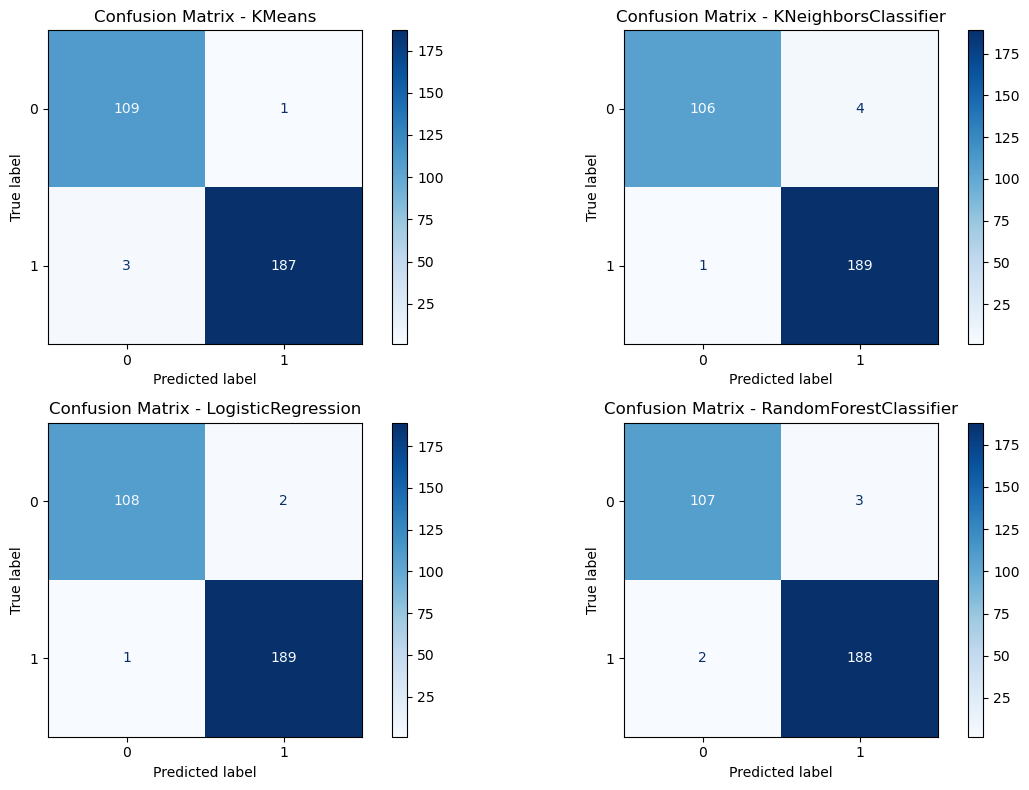

In [57]:
plot_allconfusion_subplots(all_metrics)

In [58]:
##TO DISPLAY ALL ROC GRAPH IN 1 GRAPH
def plot_allroc_curves(all_metrics, y_test, width=500, height=500):
    """
    Displays ROC curves for multiple classification models on the same graph.
    Parameters:
    - all_metrics: List of dictionaries containing model metrics including probability scores
    - y_test: True labels
    """
    import plotly.graph_objects as go  # Ensure plotly is imported
    
    fig = go.Figure()
    
    for metrics in all_metrics:
        model_name = metrics['Model']
        y_prob = metrics.get('Probability Scores', None)

        if y_prob is None:
            print(f"Skipping {model_name} - No probability scores available.")
            continue

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)

        # Add ROC curve to the figure
        fig.add_trace(go.Scatter(
            x=fpr, y=tpr,
            mode='lines',
            name=f"{model_name} (AUC = {auc_score:.2f})"
        ))

    # Add diagonal reference line for random classifier
    fig.add_shape(
        type="line", x0=0, y0=0, x1=1, y1=1, 
        line=dict(dash="dash", color="gray"),
        name="Random Classifier"
    )

    # Layout adjustments
    fig.update_layout(
        title="ROC Curves for All Models",
        xaxis_title="False Positive Rate (FPR)",
        yaxis_title="True Positive Rate (TPR)",
        width=width,
        height=height
    )

    fig.show()

In [59]:
plot_allroc_curves(all_metrics, y_test, width=1000, height=700)

Skipping KMeans - No probability scores available.


In [60]:
# List of models you want to evaluate
models = [
    kmeans_model,
    knn_model,
    logistic_model,
    rf_model,
]

for model in models:
    # Check if the model has the 'feature_importances_' attribute
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        print(f"Model: {model.__class__.__name__}")
        print(f"Feature importance: {feature_importance}")
    # Check if the model has 'coef_' attribute (for linear models like Logistic Regression)
    elif hasattr(model, 'coef_'):
        feature_importance = model.coef_[0]  # For linear models like LogisticRegression
        print(f"Model: {model.__class__.__name__}")
        print(f"Feature importance (coefficients): {feature_importance}")
    else:
        print(f"Model: {model.__class__.__name__} does not provide feature importance.")

    print("-" * 40)  # Line separator between results for each model

Model: KMeans does not provide feature importance.
----------------------------------------
Model: KNeighborsClassifier does not provide feature importance.
----------------------------------------
Model: LogisticRegression
Feature importance (coefficients): [-4.35010306  0.24628992  0.8794831   0.93668882]
----------------------------------------
Model: RandomForestClassifier
Feature importance: [0.93843605 0.0108718  0.02758316 0.02310899]
----------------------------------------


# Part 4.1 - K-means clustering, an unsupervised learning method

## Looking for the "correct" number of clusters ==> 2 as the best

### With elbow method

In [61]:
## TO PLOT K-MEANS ELBOW METHOD
def plot_k_means_elbow_method(X, k_range=range(1, 10), figsize=(600, 600)):
    """
    Plots the Elbow Method to determine the optimal number of clusters for K-Means.
    Parameters:
    - X: DataFrame or array-like, the input data for clustering.
    - k_range: range, the range of k values to test (default: 1 to 9).
    - figsize: tuple, size of the interactive figure (default: 600x600).
    Returns:
    - A Plotly interactive line chart showing the inertia values for different k.
    """

    # Store inertia values for different k
    inertia_list = []
    # Iterate over each k value
    for k in k_range:
        k_means = KMeans(n_clusters=k)
        k_means.fit(X)
        inertia_list.append(k_means.inertia_)

    # Create a DataFrame to store the results
    data = pd.DataFrame({"Number of Clusters": list(k_range), "Inertia": inertia_list})

    # Create the Elbow Method plot
    fig = px.line(
        data, 
        x="Number of Clusters", 
        y="Inertia", 
        title="Elbow Method",
        labels={"Number of Clusters": "Number of Clusters", "Inertia": "Inertia"},
        markers=True
    )
    # Customize figure layout
    fig.update_layout(
        width=figsize[0],
        height=figsize[1],
        font=dict(size=14),
        title=dict(font=dict(size=18))
    )
    # Show the figure
    fig.show()

# Example usage
# plot_k_means_elbow_method(X)

In [62]:
plot_k_means_elbow_method(X,k_range=range(1, 10), figsize=(500, 500))

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\chi

### With silhouette method

In [63]:
## TO PLOT K-MEANS SILHOUETTE METHOD
def plot_k_means_silhouette_method(X, k_range=range(2, 10), figsize=(600, 600)):
    """
    Plots the Silhouette Score Method to determine the optimal number of clusters for K-Means.
    Parameters:
    - X: DataFrame or array-like, the input data for clustering.
    - k_range: range, the range of k values to test (default: 2 to 9).
    - figsize: tuple, size of the figure in pixels for Plotly (default: (600, 600)).
    Returns:
    - Displays an interactive Plotly plot of Silhouette scores for different k values.
    """

    # Store silhouette scores for different k
    silhouette_scores = []
    # Iterate over each k value
    for k in k_range:
        k_means = KMeans(n_clusters=k, random_state=42)  # Ensure reproducibility
        cluster_labels = k_means.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, cluster_labels))

    # Create a DataFrame to store the results
    data = pd.DataFrame({"Number of Clusters": list(k_range), "Silhouette Score": silhouette_scores})

    # Create the Silhouette Method plot
    fig = px.line(
        data, 
        x="Number of Clusters", 
        y="Silhouette Score", 
        title="Silhouette Method",
        labels={"Number of Clusters": "Number of Clusters", "Silhouette Score": "Silhouette Score"},
        markers=True
    )
    # Customize figure layout
    fig.update_layout(
        width=figsize[0],
        height=figsize[1],
        font=dict(size=14),
        title=dict(font=dict(size=18))
    )
    # Show the figure
    fig.show()

# Example usage:
# plot_k_means_silhouette_method(X)

In [64]:
plot_k_means_silhouette_method(X, k_range=range(2, 10), figsize=(600, 600))

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\chimy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\chi

## Others

In [65]:
labels = kmeans_model.labels_
labels

array([1, 1, 0, ..., 1, 0, 0])

In [66]:
centroids = np.round(kmeans_model.cluster_centers_,2)
centroids

array([[ 2.09, -0.07, -0.11, -0.09],
       [-1.01,  0.03,  0.07,  0.05]])

# Part 4.2 - Logistic regression, or the prediction of probablity to belong to class 0 or to class 1

## Find the right value for hyperparamater of logistic regression

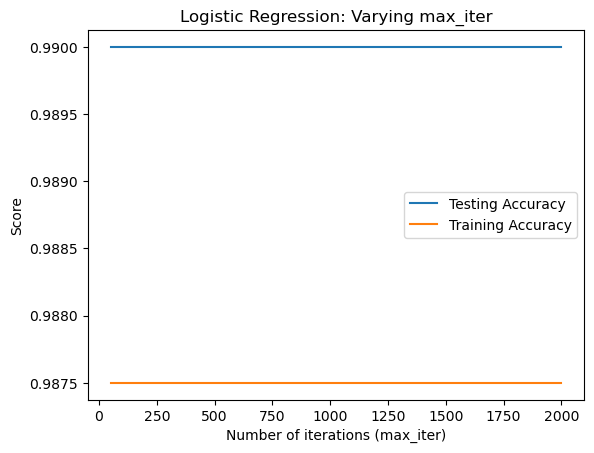

In [67]:
# Setup arrays to store train and test accuracies
iterations = np.arange(50, 2001, 50)  # Adjust range for max_iter, e.g., from 50 to 200
train_accuracy = np.empty(len(iterations))
test_accuracy = np.empty(len(iterations))

# Loop over different values of max_iter
for i, max_iter in enumerate(iterations):
    # Setup Logistic Regression with max_iter as hyperparameter
    clf = LogisticRegression(max_iter=max_iter, random_state=42)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('Logistic Regression: Varying max_iter')
plt.plot(iterations, test_accuracy, label='Testing Accuracy')
plt.plot(iterations, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of iterations (max_iter)')
plt.ylabel('Score')
plt.show()


# Part 4.3 - K-Nearest Neighbors (KNN), a supervised classification/regression method

https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn <br>
We should normalize the data after splitting it into training and test sets. This is to prevent ‘data leakage’ as the normalization would give the model additional information about the test set if we normalized all the data at once.

## Using Cross Validation to Get the Best Value of k

In [68]:
k_values = [i for i in range (1,31)]
scores = []

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_scaled, y, cv=5)
    scores.append(np.mean(score))

In [69]:
# Create DataFrame for Plotly
df_knn = pd.DataFrame({'K Values': k_values, 'Accuracy Score': scores})

# Plot using Plotly Express with adjustable width and height
fig = px.line(df_knn, x="K Values", y="Accuracy Score", markers=True, 
              title="K Values vs Accuracy Score", 
              width=800, height=500)  # Adjust width & height as needed

# Customize Labels
fig.update_layout(xaxis_title="K Values", yaxis_title="Accuracy Score")

# Show the figure
fig.show()

# Part 4.5 - Decision tree

https://www.datacamp.com/tutorial/kaggle-tutorial-machine-learning

In [70]:
# Instantiate model and fit to data
DecisionTree = tree.DecisionTreeClassifier(max_depth=3)
DecisionTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [71]:
# Make predictions
y_pred = DecisionTree.predict(X_test)

In [72]:
print("Confusion_matrix:\n",confusion_matrix(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred)) ## The higher the %, the better we can trust the confusion matrix.
print("Precision:",precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, DecisionTree.predict_proba(X_test)[:, 1]))
print("Classification report per class:\n", classification_report(y_test, y_pred))

Confusion_matrix:
 [[108   2]
 [  2 188]]
Accuracy score: 0.9866666666666667
Precision: 0.9894736842105263
Recall: 0.9894736842105263
ROC-AUC: 0.9856937799043062
Classification report per class:
               precision    recall  f1-score   support

       False       0.98      0.98      0.98       110
        True       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



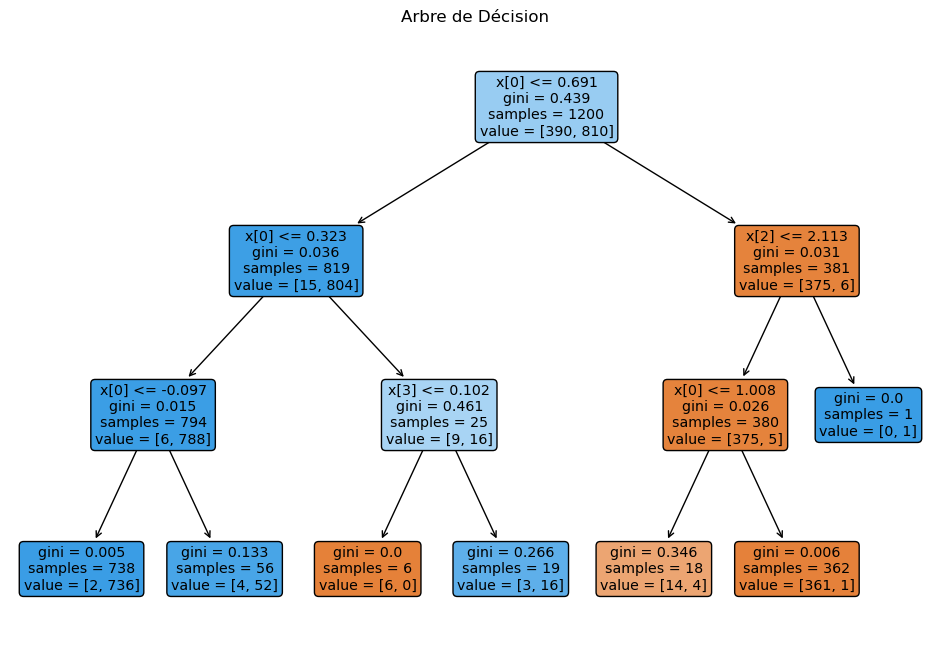

In [73]:
# Afficher l'arbre de décision
plt.figure(figsize=(12, 8))
plot_tree(DecisionTree, filled=True, rounded=True)
plt.title("Arbre de Décision")
plt.show()

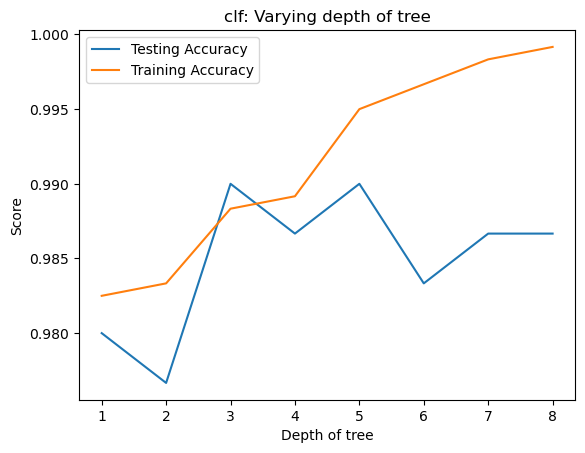

In [74]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Score')
plt.show()


# Part 4.6 - Random forest, a supervised machine learning model

https://www.datacamp.com/tutorial/random-forests-classifier-python<br>
To be completed

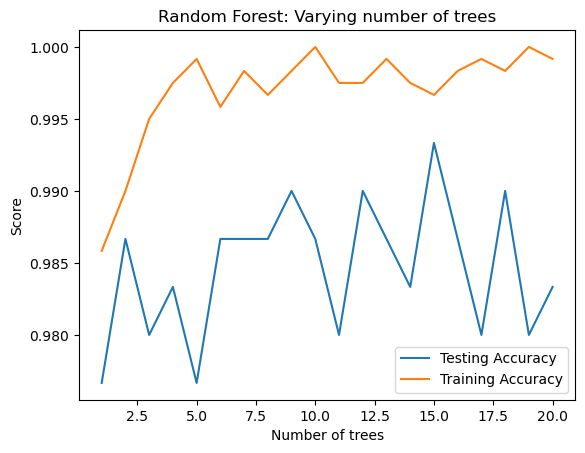

In [75]:
# Setup arrays to store train and test accuracies
n_estimators_range = np.arange(1, 21)  # You can adjust the range
train_accuracy = np.empty(len(n_estimators_range))
test_accuracy = np.empty(len(n_estimators_range))

# Loop over different values of n_estimators
for i, n in enumerate(n_estimators_range):
    # Setup a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('Random Forest: Varying number of trees')
plt.plot(n_estimators_range, test_accuracy, label='Testing Accuracy')
plt.plot(n_estimators_range, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.show()


In [76]:
print(rf_model.feature_importances_)

[0.93843605 0.0108718  0.02758316 0.02310899]


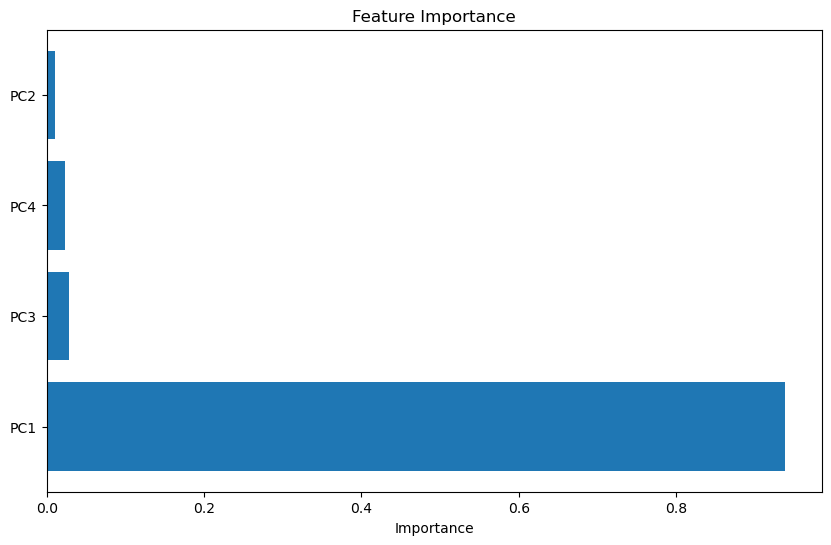

In [77]:
# Assuming clf is a fitted model like RandomForestClassifier
importances = rf_model.feature_importances_
features = df_X_proj.columns  # Names of features

# Sorting the feature importances
indices = np.argsort(importances)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), features[indices])
plt.xlabel("Importance")
plt.show()

# Part 5 - Tune hyperparameter for logistic regression model

In [78]:
print("Training Accuracy:", np.round(logistic_model.score(X_train, y_train),4)*100)
print("Testing Accuracy:", np.round(logistic_model.score(X_test, y_test),4)*100)
# If score for training much better than for testing ==> Overfitting (very good with training, but poor with testing/new)
# If both score not good ==> Biais
# If both sore are good ==> Good model

# Make predictions
y_pred = logistic_model.predict(X_test)

### TO CORRECT"
#from sklearn.metrics import r2_score
#logistic_model_r2 = r2_score(y_test, y_pred)
#print("R^2 Score:", logistic_model_r2)

Training Accuracy: 98.75
Testing Accuracy: 99.0


In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import numpy as np

# Generate synthetic dataset (replace with your real dataset)
X, y = make_classification(n_samples=1000, random_state=42)

# Define the logistic regression model
model = logistic_model

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# List to store accuracy for each fold
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)
    
    print(f"Fold {fold}: Accuracy = {acc:.4f}")

# Print mean and standard deviation
print(f"\nMean Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")


Fold 1: Accuracy = 0.8400
Fold 2: Accuracy = 0.9100
Fold 3: Accuracy = 0.8600
Fold 4: Accuracy = 0.9200
Fold 5: Accuracy = 0.8800
Fold 6: Accuracy = 0.8400
Fold 7: Accuracy = 0.8500
Fold 8: Accuracy = 0.8800
Fold 9: Accuracy = 0.8900
Fold 10: Accuracy = 0.8200

Mean Accuracy: 0.8690
Standard Deviation: 0.0308


#
<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 10px; color:#fff; ">To keep for later</h2>
</div>

<div class="alert alert-block alert-info"><b>For better efficiency, and reuse, let's define some standard python scripts, and one simple Jupyter notebook. Current Jupyter notebook must stay with a minimum of lines.</b></div>
<br> 
<div class="alert alert-block alert-info"><b>Tips for PCA (as Principal Components Analysis): <br> 1. Select relevant, complementary & many values variables. Only chose variables directly impacted our analysis. No need to keep similar variables. No need to keep variables with similar values. Only using qualitative continuous numerical data. <br> 2. Pay attention to outliers. Then work on missing values, and standardization.<br> 3. Dataframe to apply PCA on, must have individuals to analize as Index, and all variables as Columns.</b></div>
<br> 
<div class="alert alert-block alert-info"><b>Tips to prepare data for PowerBI: <br> 1. Check duplicate and missing values. Then, delete columns that are not needed (be careful of duplicate without those columns). <br> 2. Check for outliers (with mean, median, skew, kurtosis, etc.) Decide if to keep or not.<br> 3. Decide of data modelisation schema: Snowflake (as result of 1NF/2NF/3NF data normalization, more suitable for SQL) VS Star (more for PowerBI). Identify facts table (as the ones with transactions, ex: total sales, etc.), and its dimensions table (as the ones with the filter to apply, ex: customer, country, etc.). Build calendar dimension table (code to reuse). Build new table for measures. </b></div>